# Gene set enrichment calculation based on gene expression pattern similarity

The tests indicates whether genes within gene set have more similari profiles than expected by chance - eg. are tightly regulated in that sample (of multiple measurments). By default both positive and negative associations are considered.

Similarity between gene profiles within gene sets is compared to similarity between random gene pairs. The significance of gene set enrichment is calculated with Welch's t-test and adjusted with BH FDR correction.

In [11]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+'/networks/')
sys.path.insert(0, module_path+'/data_expression/')
sys.path.insert(0, module_path+'/correlation_enrichment/')

import time
import random
from math import sqrt

from statistics import (mean, stdev,median)
import matplotlib.pyplot as plt
from scipy.stats import (mannwhitneyu,ks_2samp,ttest_ind,norm)
import altair as alt
alt.renderers.enable('notebook')

from orangecontrib.bioinformatics.geneset.__init__ import (list_all,load_gene_sets)

from library import *
import functionsDENet as f

In [25]:
dataPath=module_path+'/data_expression/'
tableEID=f.loadPickle(dataPath+'trans_9repAX4_6strains_2rep_avr_T12_EID.tab')
#genesNotNullEID - Data frame of expression data with genes in rows. 
#Genes are named with Entrez IDs and all zero rows are remouved
genesFromRow=2
genesEID,genesNotNullEID=f.extractGenesFromTable(tableEID,genesFromRow,12734)

#Get gene set
list_of_genesets = list_all(organism='44689')
print(list_of_genesets)
gene_sets=load_gene_sets(list_of_genesets[2],'44689')
#Precomputed set of 500.000 random similarities (Spearman)
simsRandom=f.loadPickle('data/random500000.pkl')

#Objects for testing:
# The data is specific for one sample (here AX4 avergaed) and genes with 0 expression in all data (time) points are remouved.
genesStrainEID, genesStrainNNEID=f.genesByStrain(genesNotNullEID,tableEID,12735,'AX4_avr',genesFromRow)
sc=SimilarityCalculator()
ge=GeneExpression(genesStrainNNEID)
rscn=RandomSimilarityCalculatorNavigator(ge,sc)
gsscn=GeneSetSimilarityCalculatorNavigator(ge,sc,rscn)
rss=RandomMeanStorage(simsRandom)
ec=EnrichmentCalculator(random_storage=rss,gene_set_calculator=gsscn)


[('GO', 'cellular_component'), ('GO', 'biological_process'), ('Dictybase', 'Phenotypes'), ('GO', 'molecular_function'), ('KEGG', 'Pathways')]


In [3]:
#Helper functions

#Plot point based histogram (points of bin heights connected with line)
#Description - for legend, width - line width,
# rm_zeros - remove zero count points from line ploting (if graph will be later ploted with log scale),
# annotation - add annotation to beginning of the line
# pdfORcdf - plot proportion of counts in a bin or cumulative of the former
def point_hist(data,ax,legend_description='',width=1,bins=10,rm_zeros=False,annotation="",pdfORcdf=True,proportion=False):
    #Bins
    counts, bin_edges = np.histogram(data, bins)
    bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2.
    if proportion:
        counts=counts/len(data)
    x=bin_centres
    y=counts
    if not pdfORcdf:
        cdf=[]
        position=0
        for count in counts:
            if position==0:
                cdf.append(count)
            else:
                cdf.append(count+cdf[position-1])
            position+=1
        y=cdf
    #Plot points
    ax.scatter(x, y, s=8, label=legend_description)
    #Annotate
    if annotation !='':
        ax.annotate(annotation,(bin_centres[0],counts[0]))
    #Plot line
    count_counts = 0
    if rm_zeros:
        y_NN = []
        x_NN = []
        for count in y:
            if count != 0:
                y_NN.append(y[count_counts])
                x_NN.append(x[count_counts])
            count_counts += 1
        x=x_NN
        y=y_NN
    ax.plot(x, y,linewidth=width)

#Calculates summary statistics of random samples
#random_similarities - list of random similarities to take samples from
#sample_size - individual sample size
#n_samples - number of samples to take
#summary_stats - summary statistics  to use on each sample , 'mean' or 'median'
#Returns list of summary statistics for individual samples
def random_samples(random_similarities:list,sample_size:int,n_samples:int,summary_stats) ->list:
    randomStats = []
    for i in range(n_samples):
        # randomSampleStat = summary_stats_function(rscn.similarities(sample_size))
        # Faster - uses only precomputed correlations from smaller population
        #Np choice without replacement is slower than list version (but not if used with replacement)
        #randomSampleStat = summary_stats_function(npran.choice(random_similarities, sample_size,replace=False))
        sample=random.sample(random_similarities, sample_size)
        #Np mean quicker than list mean, even when included converting to np.array; but list median quicker than if converted to np array
        randomSampleStat=calculate_summary_stats(sample,summary_stats)
        randomStats.append(randomSampleStat)
    return randomStats

#Calculates p value for sample summary statistics vs summary statistic of samples from random population
#similarities - sample similarities
#n_samples - initial number of permutations
#Other args as in random_samples
def calculate_permutation_p(similarities,random_similarities,summary_stats,n_samples=1000):
    sample_stat=calculate_summary_stats(similarities,summary_stats)
    sample_size=len(similarities)
    #random_similarities=np.array(random_similarities)
    p,randomMeans=permutation_p(sample_stat,random_similarities, sample_size, n_samples, summary_stats)
    repeats=0
    while p<=(1/n_samples)*10:
        print(p,(1/n_samples)*10)
        if repeats>=2:
            break
        repeats+=1
        n_samples=n_samples*10
        p,randomMeans=permutation_p(sample_stat,random_similarities, sample_size, n_samples, summary_stats)
    return (p,randomMeans)

#Calculate summary statistics
#data - the sample for calculation
#summary_stats:'mean','median'
def calculate_summary_stats(data:list,summary_stats:str='mean'):
    if summary_stats == 'mean':
        stat = np.array(data).mean()
    if summary_stats == 'median':
        stat = median(data)
    return stat

#Helper function for calculate_bootstrap_p
#sample_stat - statistics on the sample
#Other arguments as in random_samples
def permutation_p(sample_stat,random_similarities, sample_size, n_samples, summary_stats='mean'):
    randomMeans = np.array(random_samples(random_similarities, sample_size, n_samples, summary_stats))
    #Quicker than list comprehention
    greater = (randomMeans>=sample_stat).sum()
    p = greater / n_samples
    return (p,randomMeans)

#Estimates se scaling for medians distribution based on n_pairs (sample size) and n permutations (n samples)
def se_scaling_estimation(n_pair:int,permutations:int):
    stats=random_samples(simsRandom, n_pair, permutations, 'median')
    centerFit, seFit = norm.fit(stats)
    observed_se_scaling = seFit * sqrt(n_pair) / sd
    return observed_se_scaling

#Get number of pairs from points and scaling factor for that number of pairs
#n_points - eg. n genes
#permutations - as in se_scaling_estimation
#Return tupple with list of n_similarities for each n_points as first element and list of scaling factors as second element
def se_scalings_estimation(n_points:list,permutations:int):
    n_pairs = []
    scalings = []
    for n_point in n_points:
        n = possible_pairs(n_point)
        n_pairs.append(n)
        scalings.append(se_scaling_estimation(n,permutations))
    return(n_pairs,scalings)

def log_fit_to_function(fit):
    b1=fit[0]
    b0=fit[1]
    def F(x):
        return b1*np.log(x)+b0
    return F

#Converts poly fit with degree up to 5 to function
def poly_fit_to_function(fit,is_log=False):
    degree=len(fit)-1
    if degree<=5:
        b0=fit[degree]
        coeffs = list(fit[:degree])
        while len(coeffs) < 5:
            coeffs.insert(0, 0)
        b5=coeffs[0]
        b4=coeffs[1]
        b3 = coeffs[2]
        b2 = coeffs[3]
        b1 = coeffs[4]
        if not is_log:
            def F(x):
                y=b5*x**5+b4*x**4+b3*x**3+b2*x**2+b1*x+b0
                return y
        else:
            def F(x):
                y=b5*np.log(x)**5+b4*np.log(x)**4+b3*np.log(x)**3+b2*np.log(x)**2+b1*np.log(x)+b0
                return y
        return F

#Find y based on y-s of (2) neighbouring x-s. If x is in data_x return data_y value
#Data_x must be sorted from smallest to largest, it can not have repeated values
def fit_neighbours(data_x:list,data_y:list,x:int):
    if x in data_x:
        index=data_x.index(x)
        return data_y[index]
    elif x<min(data_x):
        return data_y[0]
    elif x>max(data_x):
        return data_y[len(data_y)-1]
    else:
        for i in range(len(data_x)):
            if data_x[i]<x and data_x[i+1]>x:
                y=(data_y[i]+data_y[i+1])/2
                return y
            
# Retain sets that are present in at least min_replicates replicates at level of max padj, average the padj
# Reps data - list of enrichment data, where list elements are dicts (resDict) of gene set names (key) and padj (value)
def merge_from_replicates(reps_data: list, max_padj, min_reps: int = 2) -> dict:
    merged = dict()
    for data in reps_data:
        for gene_set, padj in data.items():
            if padj <= max_padj:
                if gene_set in merged.keys():
                    merged[gene_set].append(padj)
                else:
                    merged[gene_set] = [padj]
    filtered = dict()
    for gene_set, padjs in merged.items():
        if len(padjs) >= min_reps:
            filtered[gene_set] = mean(padjs)
    return filtered


## Distribution of similarities

In [ ]:
#Plot similarities distribution for random pairs (bold) and gene sets,
# add  Kolmogorov Smernov two-sided p values to line starts (compares medians) and whether mean is greater than random mean (T/F)
#Print out gene set name and number of genes

#Should log y scale be used
use_log=False
#Plot  histogram or cumulative  histogram
pdfORcdf=True
# Convert counts into porportions (count in bin/total N similarities)
proportion=True
#Which test to use: Mann-Whitney: 'MW', Kolmogorov Smernov: 'KS' or permutation mean based 'pm', Welsch t test: 'Wt'
test='pm'
fig = plt.figure()
ax = fig.add_subplot(111)
#max_sims - Max number of similarities to calculate for random pairs/any gene set
max_sims=1000
max_sims_random=5000
#Add random
simsRandom=rscn.similarities(max_sims_random)
mRandom=mean(simsRandom)
point_hist(simsRandom,ax,'random'+' m: '+str(round(mRandom,2)),width=3,rm_zeros=use_log,annotation='rand'+str(round(mRandom,2)),pdfORcdf=pdfORcdf,proportion=proportion)
#print(median(simsRandom))
#Add sets similarities
count_sets=0
set_num=0
#How many sets to plot
while count_sets< 8:
    gene_set=list(gene_sets)[set_num]
    set_num+=1
    try:
        sims=gsscn.similarities(gene_set.genes,max_sims)
        #print(median(sims))
        count_sets+=1
        p=None
        m=mean(sims)
        if test=='KS':
            p=ks_2samp(sims,simsRandom)[1]
        elif test == 'MW':
            p = mannwhitneyu(sims, simsRandom,alternative='greater')[1]
        elif test=='Wt':
            t, p2 = ttest_ind(sims,simsRandom,equal_var=False)
            p = p2 / 2
            if t < 0:
                p = 1 - p
        elif test=='pm':
            p,randomMeans=calculate_permutation_p(sims,simsRandom,'mean')
        point_hist(sims,ax,gene_set.name +' N: '+ str(len(gene_set.genes))+' m: '+str(round(m,2))+' p: '+str(round(p,4)),rm_zeros=use_log,annotation=str(round(p,3))+' '+str(round(m,3)),pdfORcdf=pdfORcdf,proportion=proportion)
        print(gene_set.name , str(len(gene_set.genes)))
    except EnrichmentError:
        pass
plt.xlabel('Similarity bins peaks')
if proportion:
    plt.ylabel('Proportion of pairs')
else:
    plt.ylabel('Count')
if use_log:
    plt.yscale('log')
#plt.legend(loc='upper left')


A rather good example of above (others are more messy) with Mann-Whitney upper alternative p value as annotation. 
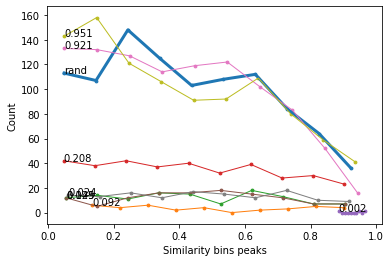
Kolmogorov Smernov: When similarities vary more everything is significant (T/F - is mean greater than random mean).
Even distributions hat do not seem to be spatially enriched have very small p values due to variability (and large sample sizes - would lead to automatic loss of small, more specific, gene sets).
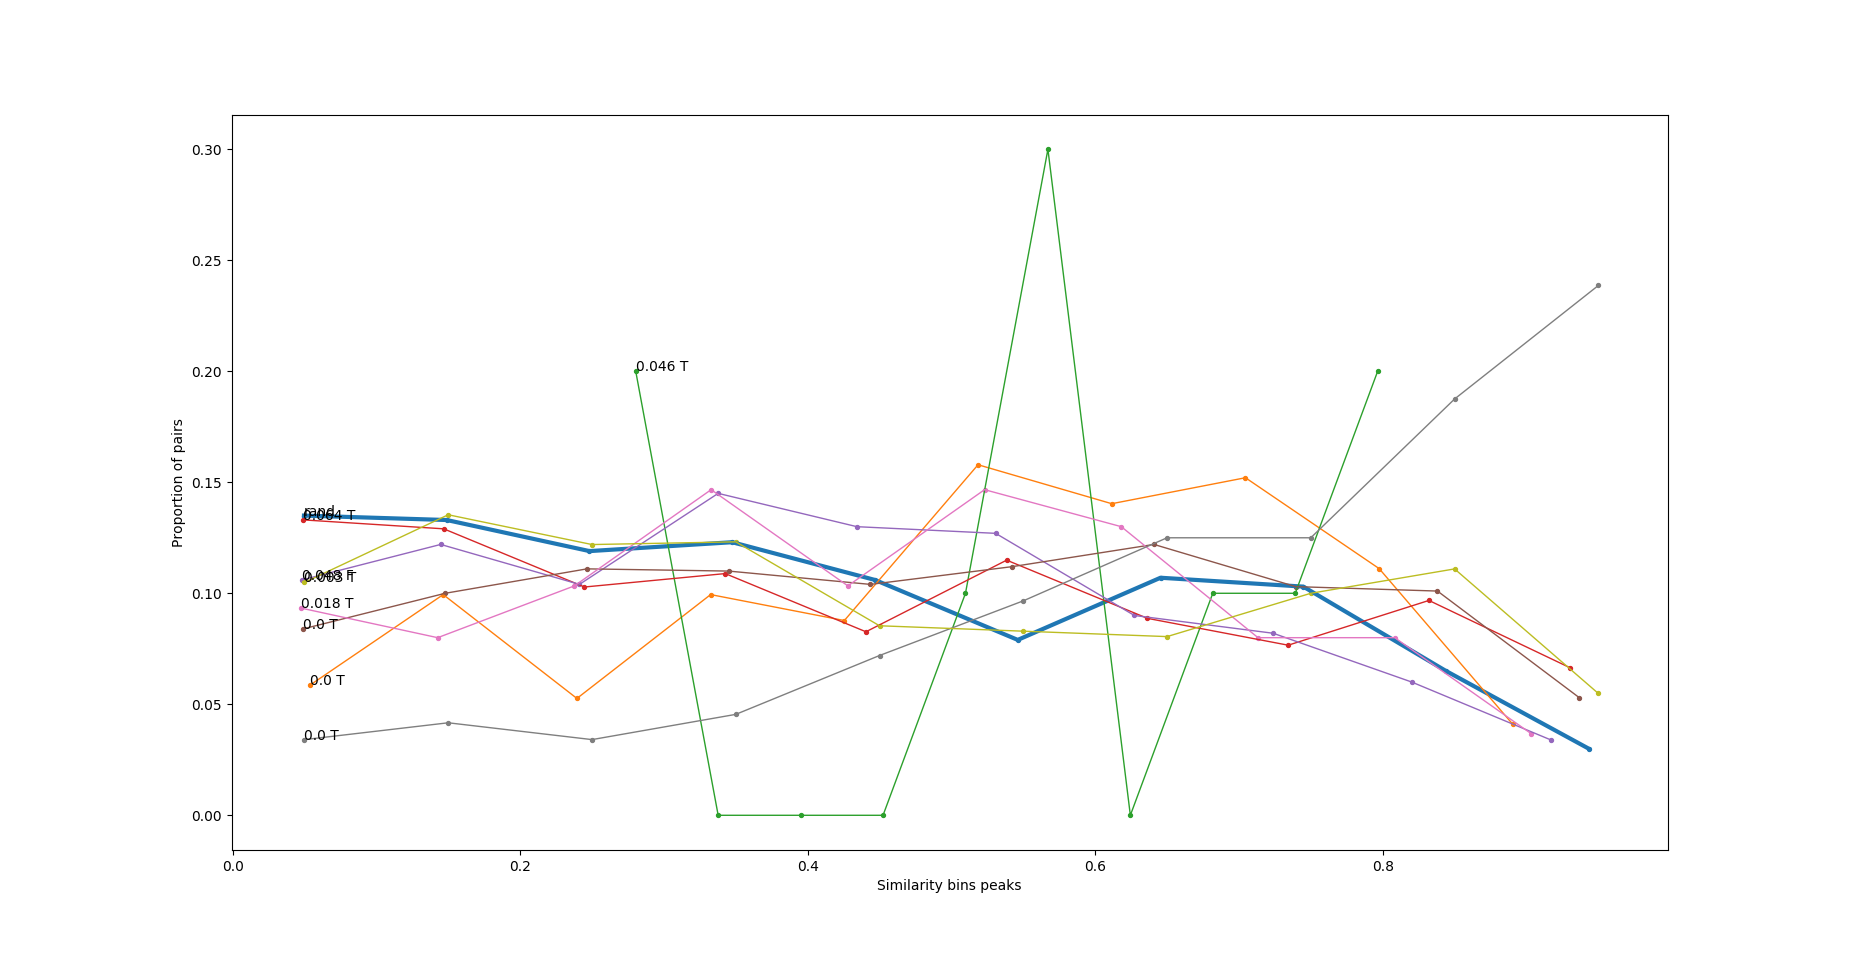
First number of annotation is p as above, second is mean.
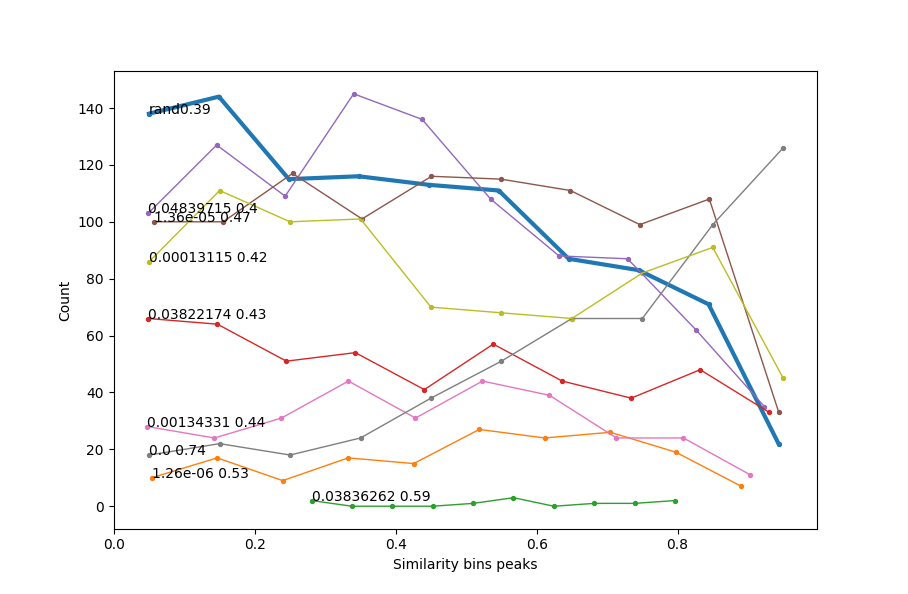

## Distribution of random sample summary statistics based on sample size

In [ ]:
#Make histograms of summary statistics for different random pairs sample sizes (based on number of similarities, not points)
#sample_sizes=[6,10,15,21,40,100,500,1000,5000,10000] # N similarities
sample_sizes=[] # N similarities
n_points=[3,6,15,20,100,200]
for point_n in n_points:
    sample_sizes.append(possible_pairs(point_n))
n_samples=1000
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
#Uncomment selected function
summary_function='mean'
#summary_function='median'
index=0
for sample_size in sample_sizes:
    print(sample_size)
    means=random_samples(simsRandom,sample_size,n_samples,summary_function)
    point_hist(means,ax,'points: '+str(n_points[index])+' sims: '+str(sample_size),rm_zeros=False)
    index+=1

plt.xlabel('Random similarity sample '+summary_function)
plt.ylabel('Count')
plt.legend(title='Similarities sample sizes')

## Permutation tests examples
p values will need to be calculated on many decimals to enable sorting of enriched gene sets.

In [ ]:
#Plot gene set summary statistic vs distribution of random summary statistics
#Left plot - distribution of random summary statistics with marked sample summary statistics and permutation test p value
#right plot - distribution of similarities for random sample and gene set
count_sets=0
set_num=0
n_sets=5
max_sims=1000
summary_function='mean'
#How many sets to plot
plt.figure(figsize=(12,12))
while count_sets< n_sets:
    #Add int to set_num to try other gene sets
    gene_set=list(gene_sets)[set_num+20]
    set_num+=1
    try:
        sims=gsscn.similarities(gene_set.genes,max_sims)
        #print(median(sims))
        p=None
        m=calculate_summary_stats(sims,summary_function)
        size_sims=len(sims)
        bootstraps=10000
        p,randomMeans=calculate_permutation_p(sims,simsRandom,'mean')
        ax1 =plt.subplot(n_sets , 2, count_sets*2+1)
        ax1.hist(randomMeans, weights=np.ones(len(randomMeans)) / len(randomMeans),bins=20)
        ax1.vlines(m,0,0.33)
        plt.ylabel('Proportion')
        plt.xlabel("Sample's "+summary_function)
        ax1.annotate('p='+str(p), (m+m/100, 0.15))

        ax2 = plt.subplot(n_sets, 2, count_sets*2+2)
        point_hist(sims,ax2,legend_description=gene_set.name +" N: "+str(len(gene_set.genes)),proportion=True)
        point_hist(simsRandom, ax2, legend_description='random',proportion=True)
        ax2.legend(prop={'size': 6})
        plt.ylabel('Proportion')
        plt.xlabel('Similarities')
        print(gene_set.name , str(len(gene_set.genes)))
        count_sets+=1
    except EnrichmentError:
        pass

### Permutation test speed testing
The test is too slow to acquire low p values needed for gene set sorting.

In [ ]:
#Time permutation test based on number of permutations/smallest possible p value
#This is not the same as whole proces of p value calculation, as there permutation tests are repeated with more permutation if p value is low
p_decimals=5 # Number of decimals for p value: the p value is not necessarily reliable to this decimal
bootstraps=10**p_decimals # Number of permutations required to obtain such a decimal (any digits from 0 to 9 on it)
sample_size=500 # Each sample will be of this size
random_population_size=500000  # Samples drawn from this population
repeat_test=2 # How many times should the test be repeated for time estimation
summary_stats='mean'  # Or median
sample_stat=1 # Summary statistics for the sample, here chosen at random as it should not affect the timing
population=list(np.random.sample(random_population_size))

def time_permutation(bootstraps,sample_size,population,summary_stats,sample_stat,repeat_test):
    start=time.time()
    for i in range(repeat_test):
        permutation_p(sample_stat,population,sample_size,bootstraps,summary_stats)
    elapsed=time.time()-start
    return elapsed/repeat_test

# Calculate once
#print('Average time (sec)',time_permutation(bootstraps,sample_size,population,summary_stats,sample_stat,repeat_test))

# Plot elapsed time for different bootstraps
times=[]
decimals=[1,2,3,4,5]
for p_decimals in decimals:
    bootstraps=10**p_decimals
    print('Calculating ',bootstraps,' bootstraps for decimals',p_decimals)
    t=time_permutation(bootstraps, sample_size, population, summary_stats, sample_stat, repeat_test=1)
    times.append(t)
plt.plot(decimals,times)
plt.yscale('log')
plt.xlabel('p value decimals precision')
plt.ylabel('time (sec)')



## Estimation of permutation distribution with normal distribution

Distribution of random sample means can be estimated with normal distn with mean=population mean and se=sd_population/sqrt(sample_sizes).

Distribution of random sample medians can be approximated with normal distribution. It might be possible to estimate the distribution in advance (so that the distribution does not need to be recalculated for each sample size) with the following: mean=median and se=scaling_factor * sd_population/sqrt(sample_sizes), where scaling factor must be determined empirically. 
Approximations of medians distribution seems to be less reliable for large sample sizes. However, it visually seems to fit reasonably at the tails - where it is most cruical for estimation of small p values. (It is likely not much of interest if it is highly reliable where estimated p would be above significance cutoff).

The distribution of medians at large sample sizes is spiked (if using greater number of bins) because bins are narrower.

In [ ]:
#Estimate mean and stdev of whole population:
arr_random=np.array(simsRandom)
mu=arr_random.mean()
sd=arr_random.std()
me=median(simsRandom)

#Plot distributions of sample means/medians
#statistic='mean'
statistic='median'
index=1
plt.rcParams.update({'font.size': 8})
sizes=[3,10,50,100,500,1000]
plt.figure(figsize=(12,12))
for n in sizes:
    print('Calculating for n similarities =',n)
    plt.subplot(int(round(len(sizes)/2,0)),2,index)
    index+=1
    stats=random_samples(simsRandom, n, 5000, statistic)
    x = np.linspace(min(stats), max(stats), 100)
    plt.hist(stats,weights=np.ones(len(stats)) / len(stats),density=True,bins=12)
    #For means use predefined se and mean
    if statistic == 'mean':
        se = sd / sqrt(n)
        normal=norm.pdf(x, mu, se)
        plt.plot(x, normal)
        add_title=''
    #For median fit normal distribution to the data
    elif statistic == 'median':
        centerFit,seFit=norm.fit(stats)
        normalFit=norm.pdf(x, centerFit, seFit)
        plt.plot(x, normalFit)
        #Check how se, as used for means distribution, could be scaled to obtain se for medians
        observed_se_scaling=seFit*sqrt(n)/sd
        add_title=', observed se scaling: '+str(observed_se_scaling)
    plt.title('n='+str(n)+add_title,fontsize=8)
plt.suptitle('Distribution of random sample '+statistic+'s, n=number of similarities',fontsize=10)



### Could the se of sample medians distributions be estimated?
If the number of permutations is sufficient it is possible that scaling factor could be modeled based on a few points/similarities (sample sizes), more when number of points/similarities is small.
Alternatively, samller bootstrap sizes could be used with more sample sizes.

In [ ]:
#Plot distribution of scaling factors for se of sample medians distribution
#N points (eg. genes)
n_points=[3,4,5,6,7,8,9,10,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,33,35,37,40,42,45,47,50,55,60,70,80]
#Sample sizes - n similarities
permutations=10000
n_pairs,scalings=se_scalings_estimation(n_points,permutations)
plt.plot(n_pairs,scalings)
plt.xlabel('n similarities')
plt.ylabel('se scaling factor')


### Scaling factiors for se estimation

In [ ]:
#Try to estimate se scaling factors
#Compare how densiti of n_points sampling and n permutations affects the estimation of se
#This might need to be latter re adjusted when it becomes evident how the final run times of the two compare
#Data
#Many sample sizes, less permutations
n_points_many_points=[3,4,5,6,7,8,9,10,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,33,35,37,40,42,45,47,50,55,60,70,80]
n_pairs_many_point ,scalings_many_point =se_scalings_estimation(n_points_many_points,1000)
#Less sample sizes, more permutations
n_points_many_permutations=[3,5,7,10,20,30,50,80]
n_pairs_many_permutations ,scalings_many_permutations =se_scalings_estimation(n_points_many_permutations,5000)
#Test set
#Add some points before random addition of points to also ensure inclusion of extreme points
#The points could be in fact sampled from distribution of gene set lengths (adjusting long sets to have less points,as would be used in enrichment calculations)
n_points_test=[3,4,5,6,10,20,50,80]
for i in range(20):
    n=random.randint(3,81)
    n_points_test.append(n)
n_pairs_test ,scalings_test =se_scalings_estimation(n_points_test,2500)
scalings_test=[x for _,x in sorted(zip(n_pairs_test,scalings_test))]
n_pairs_test.sort()

In [ ]:
#Fits to data points
#Test
plt.figure(figsize=(10,10))
plt.scatter(n_pairs_test,scalings_test)
#Fit for more points
#Polinomial
fit_many_points1= poly_fit_to_function(np.polyfit(n_pairs_many_point , scalings_many_point, 3))
fits=[]
for i in n_pairs_test:
    fits.append(fit_many_points1(i))
plt.plot(n_pairs_test,fits,label='many points poly')
#Log polinomial
fit_many_points2= poly_fit_to_function(np.polyfit(np.log(n_pairs_many_point) , scalings_many_point, 2),True)
fits=[]
for i in n_pairs_test:
    fits.append(fit_many_points2(i))
plt.plot(n_pairs_test,fits,label='many points log poly')
#Based on neighbouring points
fits=[]
for i in n_pairs_test:
    fits.append(fit_neighbours(n_pairs_many_point,scalings_many_point,i))
plt.plot(n_pairs_test,fits,label='many points neighbours')

#Fit for more permutations
#Polinomial
fit_many_permutations1=poly_fit_to_function(np.polyfit(n_pairs_many_permutations , scalings_many_permutations,3))
fits=[]
for i in n_pairs_test:
    fits.append(fit_many_permutations1(i))
plt.plot(n_pairs_test,fits,label='many permutations  poly')
#Log polinomial
fit_many_permutations2= poly_fit_to_function(np.polyfit(np.log(n_pairs_many_permutations) , scalings_many_permutations, 2),True)
fits=[]
for i in n_pairs_test:
    fits.append(fit_many_permutations2(i))
plt.plot(n_pairs_test,fits,label='many permutations log poly')
#Based on neighbouring points
fits=[]
for i in n_pairs_test:
    fits.append(fit_neighbours(n_pairs_many_permutations,scalings_many_permutations,i))
plt.plot(n_pairs_test,fits,label='many permutations neighbours')

plt.legend()
plt.xlabel('N pairs')
plt.ylabel('se scaling factor')
#MSE was not calculated as it could be influenced by random distribution of test points -
# for MSE estimation they should be sampled for gene set lengths

If a better regression fit is not found, it seems that sampling a smaller number of points, more denselly sampled at smaller sample number, with more bootstraps and estimating scaling factor based on neighbours could result in reasonable fit.

### Comparison of permutation and normal fit based test results for mean and median
The data is fit based on random population, not the permutation data.

Medians might be more conservative for lower p values.

In [ ]:
#For medians and means compare normal fit results and permutation test results
#se scaling factor was estimated with neighbours based on smaller number of points with more permutations
#Median normal distribution fit: from above

#Left Plot - distribution of random means with marked gene set mean,
#Middle plot - distribution of random medians with marked gene set median,
# permutation test p value (pp) and median normal distribution based p value (pn)
#Histograms are permutation results, line fit is the normal fit (based on whole random population, not observed histogram)
#right plot - distribution of similarities for random sample and gene set
count_sets=0
set_num=0
n_sets=5
max_sims=1000
#How many sets to plot
plt.figure(figsize=(12, 12))
while count_sets< n_sets:
    # Add int to set_num to try other gene sets
    gene_set=list(gene_sets)[set_num+10]
    set_num+=1
    try:
        sims=gsscn.similarities(gene_set.genes,max_sims)
        #print(median(sims))
        size_sims=len(sims)

        #Mean based
        #Permutations
        m=calculate_summary_stats(sims,'mean')
        ppermutac, randomMeans = calculate_permutation_p(sims, simsRandom, 'mean')
        ax1 = plt.subplot(n_sets,3, count_sets * 3 + 1)
        ax1.hist(randomMeans, density=True, bins=20)
        plt.ylabel('Density')
        plt.xlabel("Sample's means")

        # Add normal distribution to sampling means
        se = sd / sqrt(size_sims)
        x = np.linspace(min(randomMeans), max(randomMeans), 100)
        normalFit = norm.pdf(x, mu, se)
        plt.plot(x, normalFit)
        pn = 1 - norm(mu, se).cdf(m)

        # Plot p values
        ax1.vlines(m, 0, max(normalFit))
        ax1.annotate('pp=' + str(ppermutac) + '\npn=' + str(pn), (m + m / 100, max(normalFit) / 3))

        #Median based
        #Permutations
        m = calculate_summary_stats(sims, 'median')
        ppermutac,randomMeans=calculate_permutation_p(sims,simsRandom,'median')
        ax1 =plt.subplot(n_sets , 3, count_sets*3+2)
        ax1.hist(randomMeans,density=True ,bins=20)
        plt.ylabel('Density')
        plt.xlabel("Sample's medians")

        #Add normal distribution to sampling medians
        scaling_fit=fit_neighbours(n_pairs_many_permutations, scalings_many_permutations, size_sims)
        se=scaling_fit*sd/sqrt(size_sims)
        x = np.linspace(min(randomMeans), max(randomMeans), 100)
        normalFit=norm.pdf(x, me, se)
        plt.plot(x, normalFit)
        pn=1-norm(me, se).cdf(m)

        #Plot p values
        ax1.vlines(m, 0, max(normalFit))
        ax1.annotate('pp='+str(ppermutac)+'\npn='+str(pn), (m+m/100, max(normalFit)/3))

        #Distributions of similarities
        ax2 = plt.subplot(n_sets, 3, count_sets*3+3)
        point_hist(sims,ax2,legend_description=gene_set.name +" N: "+str(len(gene_set.genes)),proportion=True)
        point_hist(simsRandom, ax2, legend_description='random',proportion=True)
        ax2.legend(prop={'size': 6})
        plt.ylabel('Proportion')
        plt.xlabel('Similarities')
        print(gene_set.name , str(len(gene_set.genes)))
        count_sets+=1
    except EnrichmentError:
        pass



Does not work well for very small n (eg. n=2).

In [ ]:
#Compare difference between p mean and median based on sample size:
count_sets=0
set_num=0
n_sets=100
max_sims=1000
#How many sets to plot
n_sims=[]
p_diffs=[]
p_avgs=[]
pms=[]
pmes=[]
while count_sets< n_sets:
    # Add int to set_num to try other gene sets
    gene_set=list(gene_sets)[set_num]
    set_num+=1
    try:
        sims=gsscn.similarities(gene_set.genes,max_sims)
        size_sims=len(sims)

        # mean based p value
        m = calculate_summary_stats(sims, 'mean')
        se = sd / sqrt(size_sims)
        pm = 1 - norm(mu, se).cdf(m)
        if pm<=0.1:
            count_sets += 1
            # median based p value
            m = calculate_summary_stats(sims, 'median')
            scaling_fit = fit_neighbours(n_pairs_many_permutations, scalings_many_permutations, size_sims)
            se = scaling_fit * sd / sqrt(size_sims)
            pme = 1 - norm(me, se).cdf(m)

            pms.append(pm)
            pmes.append(pme)
            p_diff=pm-pme
            p_diffs.append(p_diff)
            p_avg=(pm+pme)/2
            p_avgs.append(p_avg)
            n_sims.append(size_sims)
    except EnrichmentError:
        pass

In [ ]:
df = pd.DataFrame(list(zip(n_sims, p_diffs,p_avgs,pms,pmes)),
               columns =['N_similarities', 'p_difference','p_aerage','p_mean','p_median'])

In [ ]:
alt.Chart(df).mark_circle().encode(x='N_similarities',y='p_difference', 
                                   color=alt.Color('p_mean',scale=alt.Scale(range=['darkviolet','yellow']))
                                  ).configure_circle(size=20)


In [ ]:
alt.Chart(df).mark_circle().encode(x='N_similarities',y='p_difference', 
                                   color=alt.Color('p_median',scale=
                                                   alt.Scale(range=['darkviolet','yellow','yellowgreen','green']))
                                  ).configure_circle(size=20)

It seems that the disagreement at small sample sizes is due to high p_median values, possibly becuase of less accurate p_median estimation due to empirical se estimation. At larger sample sizes means and medians seem to be consistent, so mean could be used instead of median.

## Calculate how many random pairs must be used to estimate similarity between random points

In [ ]:
similarities=[]
#Different number of pairs
pairN=[3,4,5,10,20,40,60,100,300,500,1000,5000,10000,20000]
#Calculate similarities summary statistics from different pair numbers
print('Calculating for n points:')
for pN in pairN:
    print(pN)
    similarities.append(rscn.similarities(pN,False))
sds=[]
means=[]
#Extract means and standard deviations from summary statistics
for s in similarities:
    means.append(mean(s))
    sds.append(stdev(s))
plt.scatter(pairN,means)
plt.plot(pairN,means)
plt.xscale('log')
plt.scatter(pairN,sds)
plt.plot(pairN,sds)
plt.xlabel('n random pairs')
plt.ylabel('mean (blue) and stdev (orange) similarity')
plt.show()


Exmples of summary statistics based on n of used pairs for different similarity calculation methods.

Cosine normalised to mean 0 and stdev 1 (AX4 average)
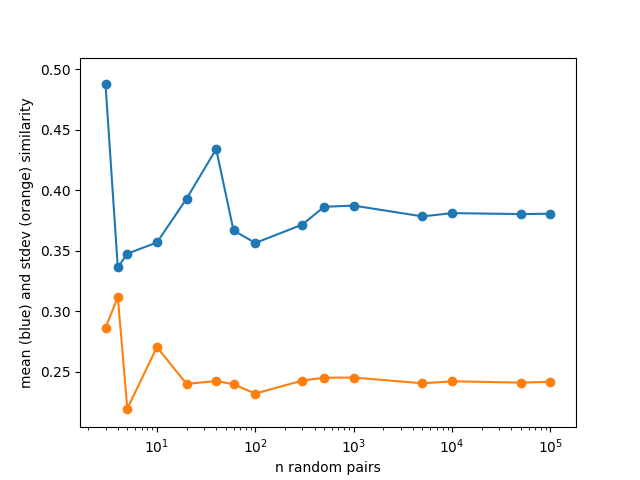

Pearson (AX4 average)
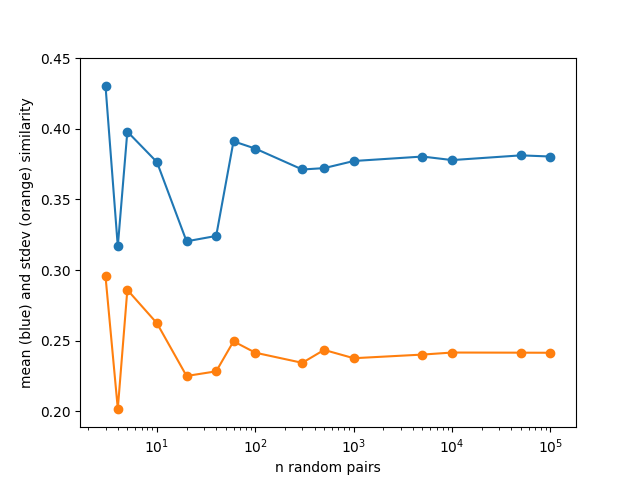

Spearman (AX4 average)
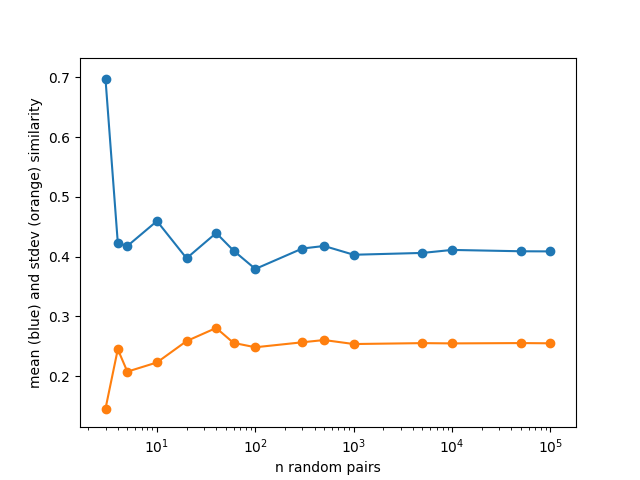

## Determine if similarities within large gene sets can be estimated with limited number of pairs

In [ ]:
#Select gene sets specified size
large_sets=[]
min_points=200
max_points=300
for s in gene_sets:
    n_genes=len(s.genes)
    if n_genes>=min_points and n_genes<=max_points:
        large_sets.append(s)
#Reduce number of sets:
max_sets=20
if len(large_sets)>max_sets:
    large_sets=large_sets[:max_sets]

#Decide on number of similarities  used for calculaion
min_possible_pair=possible_pairs(min_points)
pairN=[]
for i in range(1,11):
    pairN.append(round(min_possible_pair/20*i,0))
#Calculate p values
#TODO remember padj scale (eg. was it small/large)
results=[]
res=ec.calculate_enrichment(large_sets)
results.append(res)
for n in pairN:
    print(n)
    res=ec.calculate_enrichment(large_sets,max_pairs=n)
    results.append(res)
#MSE
mse=[]
max_se=[]
for n in range(1,len(results)):
    errorsSquared=[]
    for s in range(len(large_sets)):
        padjOriginal=results[0][s].padj
        padjShortened=results[n][s].padj
        errSq=(padjOriginal-padjShortened)**2
        errorsSquared.append(errSq)
    mse.append(mean(errorsSquared))
    max_se.append(max(errorsSquared))
#Sort for plotting
mse=[x for _, x in sorted(zip(pairN,mse), key=lambda pair: pair[0])]
max_se=[x for _, x in sorted(zip(pairN,max_se), key=lambda pair: pair[0])]
pairN=sorted(pairN)
plt.plot(pairN,mse)
plt.scatter(pairN,mse)
#plt.plot(pairN,max_se)
#plt.ylabel('MSE (blue) and max SE (orange) padj')
plt.ylabel('MSE padj')
avg_points=0
for i in large_sets:
    avg_points+=len(i.genes)
avg_pairs=possible_pairs(round(avg_points/len(large_sets),0))
plt.xlabel('n pairs (out of at least '+str(possible_pairs(min_points))+' possible, average '+str(avg_pairs)+')')


Examples for different gene set groups and similarity metrics (AX4 average, min genes = 300)

Gene set groups are biological process, cellular component and molecular function respectively.
Cosine based:
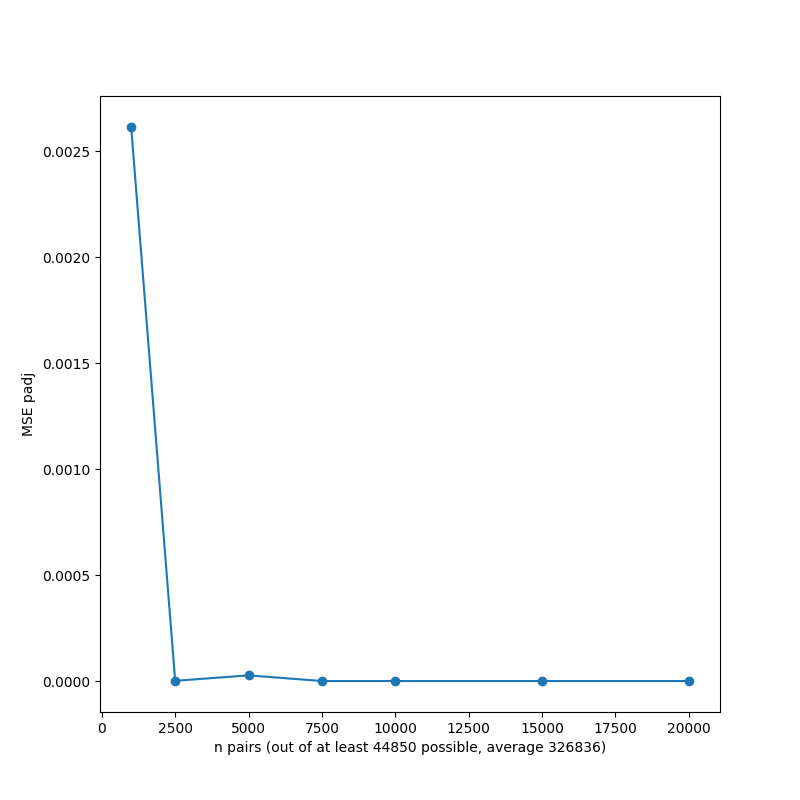
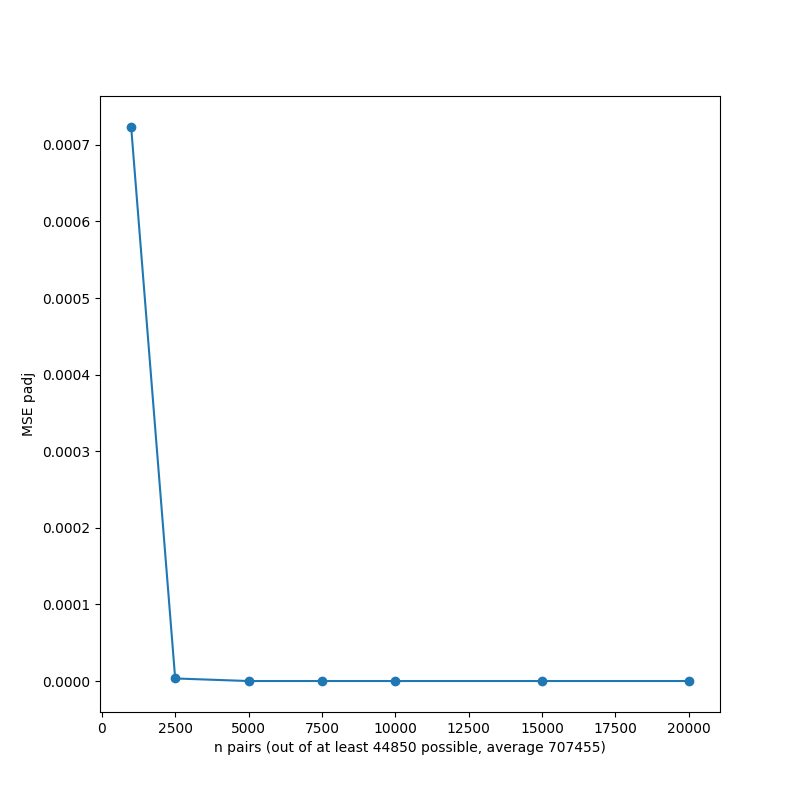
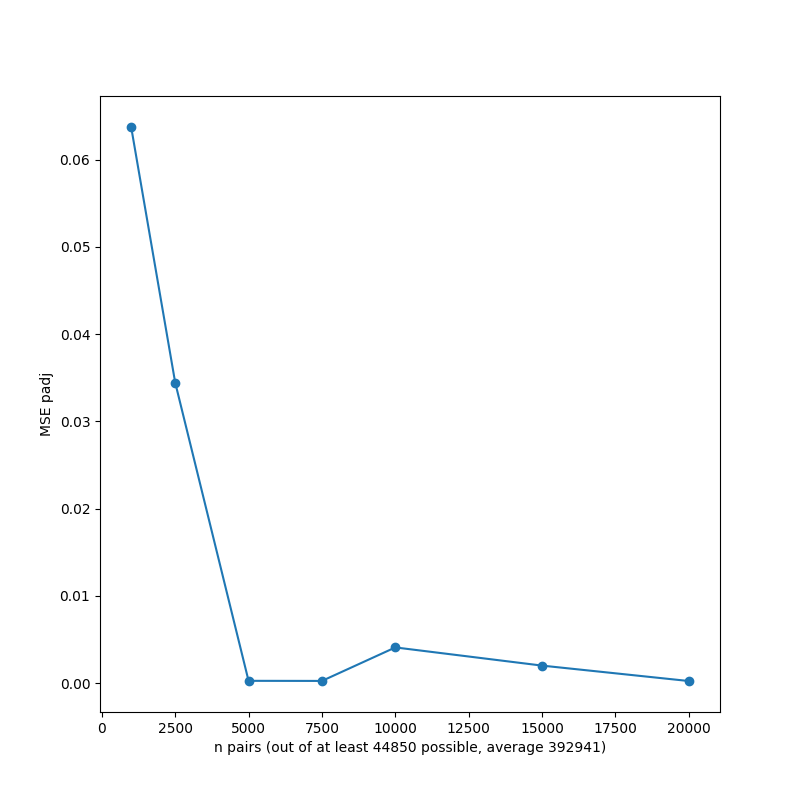

Spearman based:
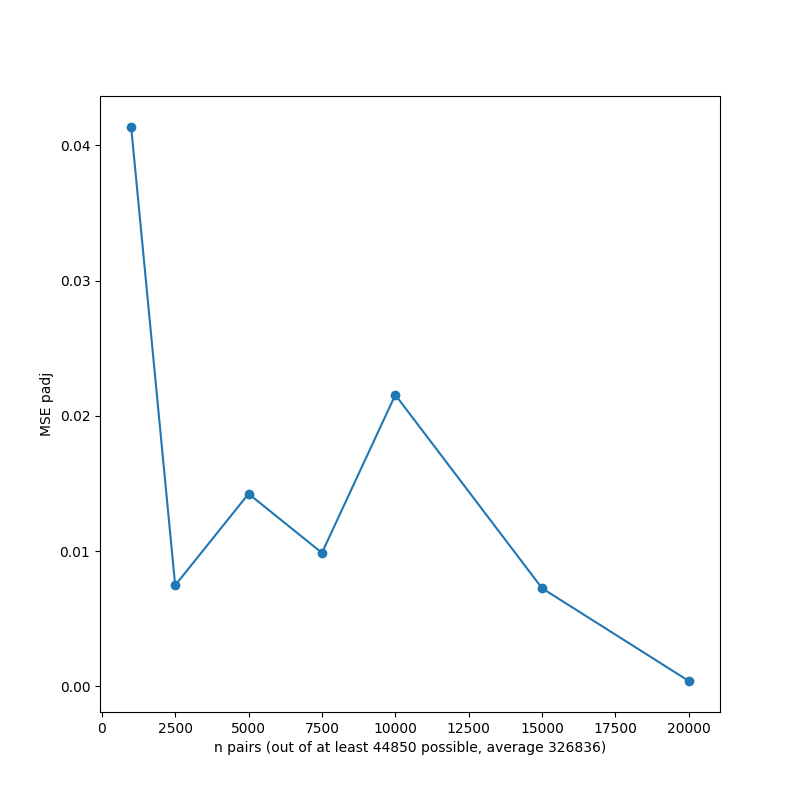
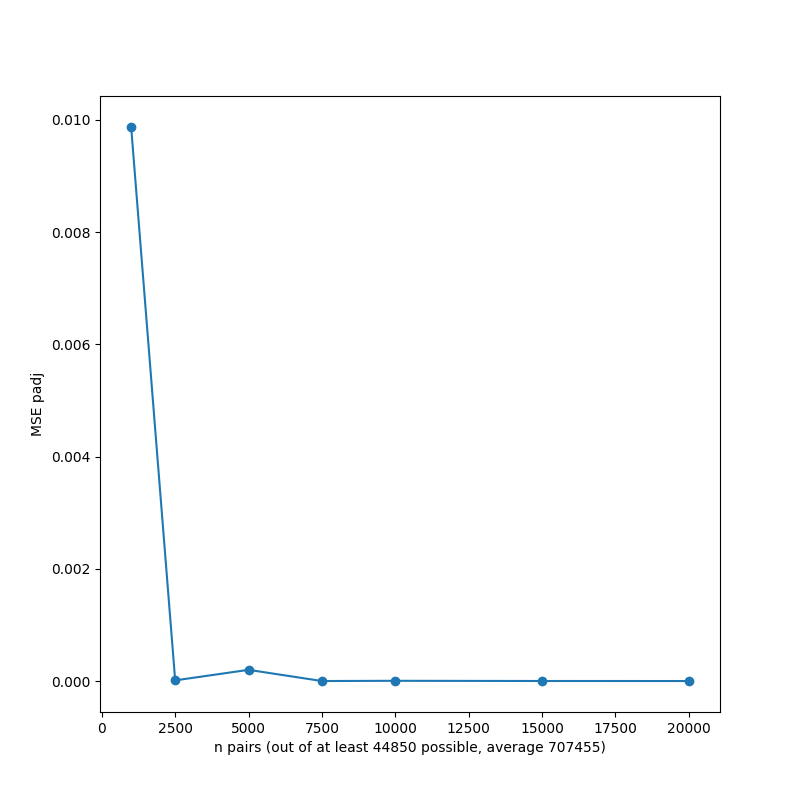
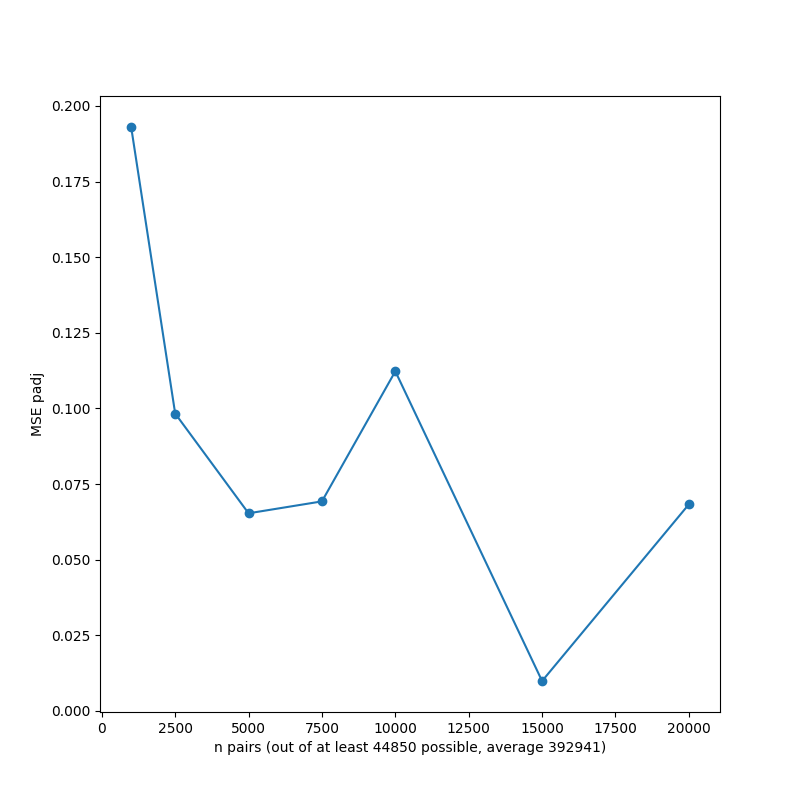

## Spearman vs cosine

In [ ]:
#Compare different parameters
#Compare difference between spearman and normalised cosine based results:
max_random_pairs=10000
sc_spearman=SimilarityCalculator(similarity_type='correlation_spearman')
sc_cosine=SimilarityCalculator(similarity_type='cosine',normalisation_type='mean0std1')
ec_cosine=EnrichmentCalculator.quick_init(ge,sc_cosine,max_random_pairs=max_random_pairs)
ec_spearman=EnrichmentCalculator.quick_init(ge,sc_spearman,max_random_pairs=max_random_pairs)

In [ ]:
max_pairs=10000
gene_sets_sub=list(gene_sets)[:50]
print('cosine')
result_cosine=ec_cosine.calculate_enrichment(gene_sets_sub,max_pairs=max_pairs)
print('spearman')
result_spearman=ec_spearman.calculate_enrichment(gene_sets_sub,max_pairs=max_pairs)

In [ ]:


padj_diff=[]
padjs_s=[]
padjs_c=[]
n_genes=[]
means_s=[]
means_c=[]
n_sims=[]
for index in range(len(result_1)):
    data_c=result_cosine[index]
    data_s=result_spearman[index]
    if data_c.gene_set is data_s.gene_set:
        padj_c=data_c.padj
        padj_s=data_s.padj
        padj_diff.append(padj_s-padj_c)
        padjs_s.append(padj_s)
        padjs_c.append(padj_c)
        n=len(data_s.gene_set.genes)
        n_genes.append(n)
        means_s.append(data_s.mean)
        means_c.append(data_c.mean)
        n_sim=possible_pairs(n)
        if n_sim>max_pairs:
            n_sim=max_pairs
        n_sims.append(n_sim)
abs_padj_diff=[abs(x) for x in padj_diff]


df = pd.DataFrame(list(zip(n_sims,n_genes, padj_diff,abs_padj_diff,padjs_s,padjs_c,means_s,means_c)),
               columns =['N_similarities', 'N_genes','padj_difference','abs_padj_difference','padj_spearman','padj_cosine',
                         'mean_spearman','mean_cosine'])

In [ ]:
alt.Chart(df).mark_circle().encode(x='N_similarities',y='padj_difference', 
                                   color=alt.Color('padj_spearman',scale=
                                                   alt.Scale(range=['darkviolet','yellow','yellowgreen','green']))
                                  ).configure_circle(size=20)

In [ ]:
alt.Chart(df).mark_circle().encode(x='N_similarities',y='padj_difference', 
                                   color=alt.Color('padj_cosine',scale=
                                                   alt.Scale(range=['darkviolet','yellow','yellowgreen','green']))
                                  ).configure_circle(size=20)

In [ ]:
alt.Chart(df).mark_circle(opacity=1).encode(alt.X('padj_cosine'
           ,scale=alt.Scale(domain=[0,1], clamp=True)
            ),
    alt.Y('padj_spearman'
          ,scale=alt.Scale(domain=[0,1], clamp=True)
         ), 
    color=alt.Color('N_similarities',scale=alt.Scale(range=['darkviolet','yellow','yellowgreen','green']))
                                  ).configure_circle(size=20)

In [ ]:
#Compare distribution of similarities of gene sets with divergent p values between cosine and spearman similarity
# x axis - proportion of similarities
# y axis - similarity
n = 0
plt.figure(figsize=(15,15))
for index in range(len(result_cosine)):
    data_c = result_cosine[index]
    data_s = result_spearman[index]
    if data_s.gene_set is data_c.gene_set:
        padj_c = data_c.padj
        padj_s = data_s.padj
        if (padj_c <= 0.05 and padj_s > 0.05) or (padj_s <= 0.05 and padj_c > 0.05):
            n += 1
            sims_cosine = ec_cosine.calculator.similarities(data_c.gene_set.genes, 10000)
            sims_spearman = ec_spearman.calculator.similarities(data_s.gene_set.genes, 10000)
            sims_random_cosine = ec_cosine.storage._similarities
            sims_random_spearman = ec_spearman.storage._similarities
            point_hist(sims_cosine, plt.subplot(3, 3, n), 'cosine ' + str(round(padj_c,3))+' sims '+str(len(sims_cosine)),proportion=True)
            point_hist(sims_spearman, plt.subplot(3, 3, n), 'spearman ' + str(round(padj_s,3))+' sims '+str(len(sims_spearman)),proportion=True)
            point_hist(sims_random_cosine, plt.subplot(3, 3, n), 'cosine random',proportion=True)
            point_hist(sims_random_spearman, plt.subplot(3, 3, n), 'spearman random',proportion=True)
            plt.legend()

            

## Compare different ways of merging replicates

In [29]:

strain='tagB'
replicates=[1,2]
# Merge replicates data when enrichment is calculated for each replicate separately:
reps = []
for rep in replicates:
    rep_data = f.loadPickle('data/enrichment_cosine_5000_pheno_' + strain + '_r' + str(rep) + '.pkl')
    resDict = dict()
    for r in rep_data:
        resDict[r.gene_set.name] = r.padj
    reps.append(resDict)
merged = merge_from_replicates(reps, 1)

# Two types of initially merged
# Merge data vertically
initially_merged_data = f.loadPickle('data/enrichment_cosine_5000_pheno_' + strain + '.pkl')
initially_merged = dict()
for r in initially_merged_data:
    initially_merged[r.gene_set.name] = r.padj
# Merge data horizontally
initially_merged_data_row = f.loadPickle('data/enrichment_cosine_5000_pheno_' + strain + '_mergedReps.pkl')
initially_merged_row = dict()
for r in initially_merged_data_row:
    initially_merged_row[r.gene_set.name] = r.padj

# Obtain data for plotting
data1 = merged
data2 = initially_merged_row
sets1 = data1.keys()
sets2 = data2.keys()
padjs1 = []
padjs2 = []
n_genes=[]
for gene_set in gene_sets:
    if (gene_set.name in sets1) or (gene_set.name in sets2):
        n_genes.append(np.log10(len(gene_set.genes)))
        if gene_set.name in sets1:
            padjs1.append(data1[gene_set.name])
        else:
            padjs1.append(1.5)
        if gene_set.name in sets2:
            padjs2.append(data2[gene_set.name])
        else:
            padjs2.append(1.5)

df = pd.DataFrame(list(zip(padjs1,padjs2,n_genes)),
               columns =['padj data1', 'padj data2','N genes log 10'])

alt.Chart(df).mark_circle().encode(x='padj data1',y='padj data2',
                                   color=alt.Color('N genes log 10',scale=
                                                   alt.Scale(range=['darkviolet','yellow','yellowgreen','green']))
                                  ).configure_circle(size=20).interactive().serve()


ModuleNotFoundError: No module named 'correlation_enrichment'

The above does currently not want to load the data, so images are below. Calculating enrichment for each replicate separately takes almost n_replicates times more time. Thus merging of replicates would seem preferable. Merging vertically (eg. having replicated genes in similarity calculation) does not work well. Thus the replicates could be merged horizontally - each similarity is calculated based on all replicates.

y - merged horizontally, x - merged by first calculating enrichment for each replicate separately
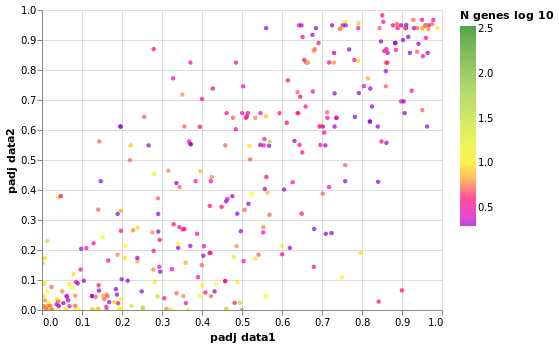
y - merged vertically, x - merged by first calculating enrichment for each replicate separately
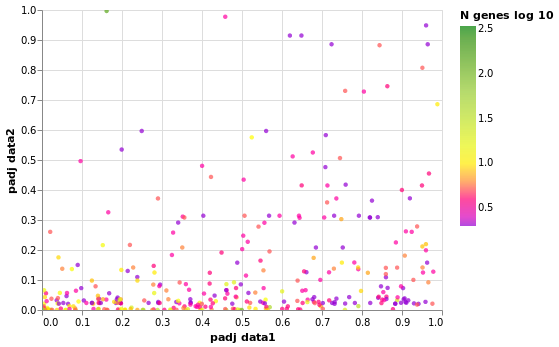

## Example usage

In [ ]:
#Make objects
similarity_calculator=SimilarityCalculator(similarity_type='cosine',normalisation_type='mean0std1')
enrichment_calculator=EnrichmentCalculator.quick_init(ge,similarity_calculator)
gsc=GeneSetComparator(enrichment_calculator.calculator)

In [ ]:
#Calculate enrichment
data=ec.calculate_enrichment(list(gene_sets)[:30],5000)

In [ ]:
#Get top 5 sets based on padj
top=EnrichmentCalculator.filter_enrichment_data_top(data,5,metric='padj')
for i in top:
    print(i.gene_set.name,'N genes:',len(i.gene_set.genes),'pval:',i.pval,'padj:',i.padj,
          'mean:',i.mean,'median:',i.median)

In [ ]:
#Example plot of gene profiles:
count=0
for gene in top[0].gene_set.genes:
    if count<20:
        count+=1
        points=pp.minmax_scale(genesStrainNNEID.loc[gene,:])
        #Replace with real time points!
        times=range(len(points))
        plt.plot(times,points,'b')
for gene in top[0].most_similar:
    points=pp.minmax_scale(genesStrainNNEID.loc[gene,:])
    #Replace with real time points!
    times=range(len(points))
    plt.plot(times,points,'r')
plt.ylabel('Min max scaled expression')
plt.xlabel('Time point number')

#Blue: first 20 genes
#Red: top 10 genes invloved in pairs with biggest profile similarity


In [ ]:
#Compare data sets based on genes with most similar profiles within data sets
pairs=gsc.make_set_pairs(top)
gsc.between_set_similarities(pairs)
gsc.changeability_similarity(pairs)

In [ ]:
index=0
for pair in pairs:
    print(index, 'mean:' ,pair.mean_profile_similarity, 
          'changeability:',pair.profile_changeability_similarity,
          pair.gene_set_data1.gene_set.name,
          'and',pair.gene_set_data2.gene_set.name)
    index+=1

In [ ]:
#Plot compared data sets
pair=pairs[9]
colour='g'
for dataset in [pair.gene_set_data1,pair.gene_set_data2]:
    count=0
    for gene in dataset.gene_set.genes:
    #for gene in dataset.most_similar:
        if count<10:
            count+=1
            points=pp.minmax_scale(genesStrainNNEID.loc[gene,:])
            #TODO: Replace with real time points!
            times=range(len(points))
            plt.plot(times,points,colour)
    colour='r'



## Example result

Calculated enrichment for Dicty phenotype gene sets for each replicate. Parameters: pearson correlation, 5000 pairs for random similarity, 3000 pairs as max for each gene set.  Replicate results from individual strains were merged by requiring individual gene sets to be present in at least two replicates, averaging p adjusted.

The runtimes were one to a couple of minutes per replicate (dependent on characteristics of gene sets used). Not all gene sets were tested so far so it is possible that some run times might be even longer. 

This data was used to create a table of starins and gene sets, containing p adjusted as table value. This was plotted in Orange.

When examining padj distribution it was discovered that many gene sets had p adjusted well below 0.05. - To obtain a narrower set of gene sets with well correlated genes any padj greater than 5th percentile padj was changed to 1 for plotting in Orange. To try to improve heatmap resolution table was perprcessed before importing in Orange by transfroming it with -10log10.

These transformations also affect strain clustering in heatmap.

Original padj values:

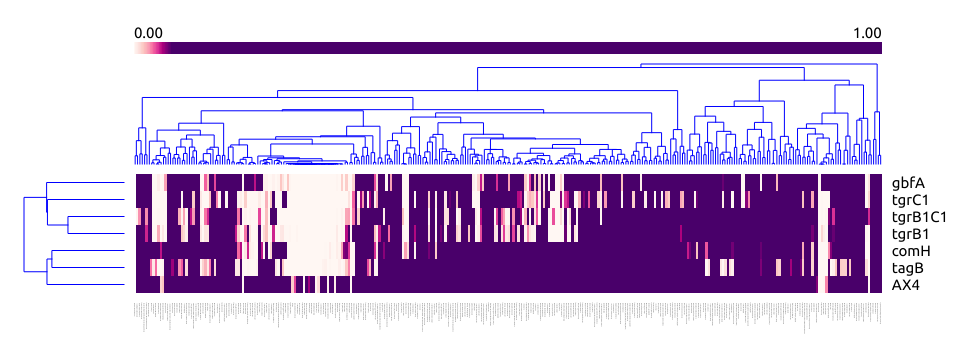


Top 5% padj filtering:
Many of top enriched phenotypes seem to be relevant for fruiting body development. What I find odd is the wild type gene set enrichment pattern - is it possible that WT gene set is in fact marker for unicelaular stage WT?

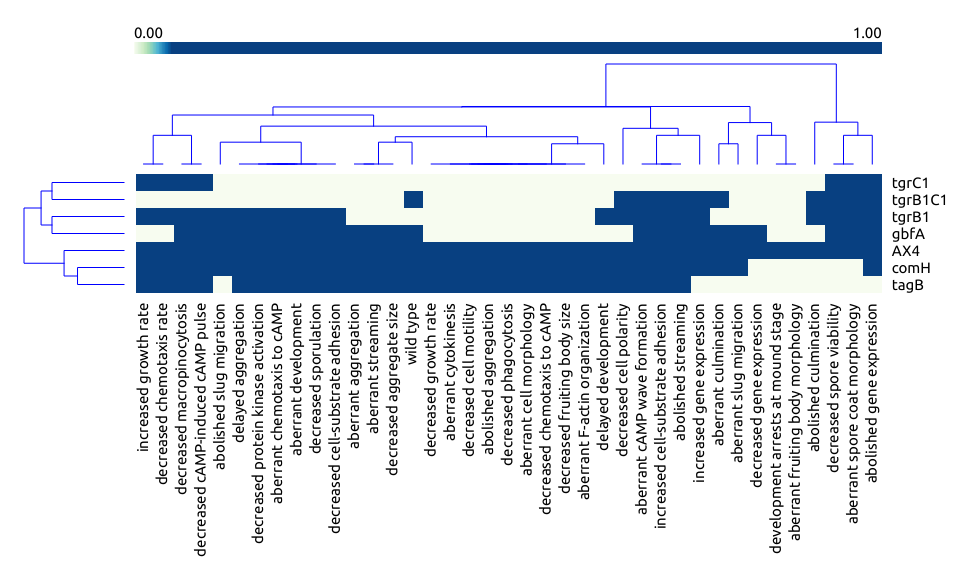

-10log10 transformed padj
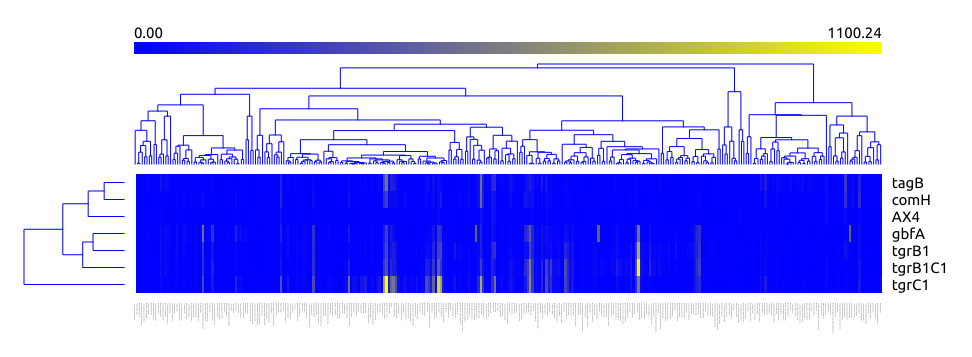

In [ ]:
#Main code parts used for above analysis:

#Calculation for single replicate:
ge=GeneExpression(genes)
ec=EnrichmentCalculator(ge,sc)
result=ec.calculate_enrichment(gene_sets,3000)
resDict=dict()
for r in result:
    resDict[r.gene_set.name]=r.padj


#Retain sets that are present in at least min_replicates replicates at level of max padj, average the padj
#Reps data - list of enrichment data, where list elements are dicts (resDict) of gene set names (key) and padj (value)
#Returns in same format as resDict
def merge_from_replicates(reps_data:list, max_padj,min_reps:int=2)->dict:
    merged=dict()
    for data in reps_data:
        for gene_set,padj in data.items():
            if padj<=max_padj:
                if gene_set in merged.keys():
                    merged[gene_set].append(padj)
                else:
                    merged[gene_set]=[padj]
    filtered=dict()
    for gene_set,padjs in merged.items():
        if len(padjs)>=min_reps:
            filtered[gene_set]=mean(padjs)
    return filtered

#Merge replicates data:
#Data of individual strains, keys are strain names, values are strain results (as described below)
strain_data=dict()
#Add data of each replicate (resDict) to reps list
reps=[]
#Decided not to filter on pval as Ornage cant plot heatmap NaN well
merged=merge_from_replicates(reps,1)
strain_data[strain]=merged
#Make enrichment table
strains=[]
datas=[]
for strain,data in strain_data.items():
    strains.append(strain)
    datas.append(data)
table_enriched=pd.DataFrame(datas)
table_enriched.index=strains

#Retain only best pvals, replace others with 1
padjs=table_enriched.values.flatten()
table_filtered=table_enriched.copy()
boundary=np.nanpercentile(padjs,5)
table_filtered[table_filtered>boundary]=1

#Log transform -10log10(val)
table_log=np.log10(table_enriched)
table_log=table_log*-10


## Conclusion

It seems that results are biologically meaningful. 

However, the run times are sub optimal. One of the ways this could be improved is by using only gene sets low in gene set hierarchy, where possible. - Eg. not using very functionally broad gene sets with many genes.